# Predicting Wine Quality

## Andreas Christofi

## 1. Setup

### 1.1 Libraries

In [1]:
# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams['figure.dpi'] = 70

# sklearn modules
import sklearn
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier, OutputCodeClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

import scipy
from scipy.stats import skew

### 1.2 Data

In [2]:
wine_train = pd.read_csv("wine_qual_train.csv")
wine_test  = pd.read_csv("wine_qual_test.csv")

### 1.3 Necessary Functions 

In [3]:
def run_model(model, x_train, y_train, x_test, y_test, multi='none', ridge=False):
    if multi == 'one':
        model = OneVsOneClassifier(model)
    elif multi == 'rest':
        model = OneVsRestClassifier(model)
    elif multi == 'output':
        model = OutputCodeClassifier(model)
        
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    print("Train score: ", f1_score(model.predict(x_train), y_train, average='weighted'))
    print("Test score: " , f1_score(preds, y_test, average='weighted'))
    
    scores = cross_validate(model, x_test,y_test, cv=5, scoring='f1_weighted')
    print("Cross validation score: ",scores["test_score"].mean())
    cm = pd.DataFrame(confusion_matrix(preds, y_test, labels=['Poor','Average','Good','Excellent']), 
                      columns=['Poor','Average','Good','Excellent'], index=['Poor','Average','Good','Excellent'])
    print(cm)
    if (multi == 'rest') & (ridge == False):
        ovr_roc_plot(y_test, model.predict_proba(x_test))
    return classification_report(preds, y_test)

In [4]:
def run_all(clf, x_train, y_train, x_test, y_test, ridge = False):
    print(type(clf).__name__ +" :\n")
    print(run_model(clf, x_train, y_train, x_test, y_test, multi='none', ridge=ridge))
    print('-----------------------------\nOne vs. One: \n')
    print(run_model(clf, x_train, y_train, x_test, y_test, multi='one', ridge=ridge))
    print("-----------------------------\nOne vs. Rest: \n") 
    print(run_model(clf, x_train, y_train, x_test, y_test, multi='rest', ridge=ridge))
    print('-----------------------------\nOutput correction: \n')
    print(run_model(clf, x_train, y_train, x_test, y_test, multi='output', ridge=ridge))

In [5]:
"""
One-vs-rest ROC curves
The function below implements this considering each class separately and calculating a unique ROC and AUC for each.
"""
def ovr_roc_plot(y_true, y_pred):
    """ Draw ROC curves using one-vs-rest approach
    """
    
    classes = list(set(y_true))
    n_classes = len(classes)
    
    # Convert from n x 1 categorical matrix to n x k binary matrix
    y_true = sklearn.preprocessing.label_binarize(y_true, classes)
    #y_pred = sklearn.preprocessing.label_binarize(y_pred, classes)
    # Sanity Check
    if y_true.shape[1] != y_pred.shape[1]:
        raise ValueError("Truth and prediction dimensions do not match.")
    
    # Compute ROC curve and ROC area for each class
    rocs = dict() 
    aucs = dict() 
    for name, i in zip(classes, range(n_classes)):
        aucs[i] = pd.DataFrame({ 
            'Quality': [name],
            'auc': [sklearn.metrics.roc_auc_score(y_true[:, i], y_pred[:, i])]
        })
        
        rocs[i] = pd.DataFrame(
            data = np.c_[sklearn.metrics.roc_curve(y_true[:, i], y_pred[:, i])],
            columns = ('fpr', 'tpr', 'threshold')
        ).assign(
            Quality = name
        )
    
    # Bind rows to create a single data frame for each
    roc = pd.concat(rocs)
    auc = pd.concat(aucs)
    
    # Create plot
    sns.lineplot(x='fpr', y='tpr', hue='Quality', data=roc, ci=None)

    plt.plot([0,1],[0,1], 'k--', alpha=0.5) # 0-1 line 
    plt.title("ROC ovr curves")
             
    plt.show()
    
    # Return the AUCs as a Data Frame
    return(auc)

In [6]:
def run_rfe_and_score_best_feature(model, x_train, y_train, x_test, y_test, n=10):
    print('--------------------------------------------------------------')
    print("Running ",type(model).__name__)
    
    selector = RFE(model, n, step=1)
    selector = selector.fit(x_train,y_train)

    features = get_top_features(x_train, selector.ranking_)
    
    model.fit(x_train[features],y_train)
    preds=model.predict(x_test[features])
    
    print("Train score: ", f1_score(model.predict(x_train[features]), y_train, average='weighted'))
    print("Test score: " , f1_score(preds, y_test, average='weighted'))
    
    scores = cross_validate(model, x_train[features],y_train, cv=5, scoring='f1_weighted')
    print("Cross validation score: ",scores["test_score"].mean())
    
    return features
        
    
def get_top_features(features, importances):
    zipped_and_sorted = sorted(zip(features, importances), key=lambda x: x[1])
    result = [x[0] for x in zipped_and_sorted if x[1] == 1]
    return result

## 2. Exploratory Data Analysis and Preprocessing

We will be using data for exploring the quality and physicochemical characteristics of Portuguese Vinho Verde wine. These data come from a paper published by Cortez, et al. in Decision Support Systems in 2009, this paper has been included in the project folder. These data were developed for the purpose of predicting the quality of the wine based on its physicochemical characteristics.

Below is a brief description of these features / physicochemical characteristics:

* `quality` - score between 0 (worst) to 10 (best) based on blind taste tests
* `wine` - type of wine, either `white` or `red`
* `fixed_acidity` - grams of tartaric acid / dm$^3$
* `volatile_acidity` - grams of acetic acid / dm$^3$
* `citric_acid` - grams of citric acid / dm$^3$
* `residual_sugar` - grams / dm$^3$
* `chlorides` - grams of sodium chloride / dm$^3$
* `free_sulfur_dioxide` - milligram / dm$^3$
* `total_sulfur_dioxide` - milligram / dm$^3$
* `density` - g/cm$^3$
* `pH` - acidity
* `sulphates` - grams of potassium sulphate / dm$^3$
* `alcohol` - percent alcohol by volume

We are going to make an exploratory Data Analysis to understand better the features of the analysis.
For further study of the data we make some plots to see the relationship between the quality and the explanotary variables.

In [7]:
'''
The first thing that we have to do is to check if there are missing values in our data set.
'''
#check for missing values
wine_train.isnull().sum()

quality                 0
wine                    0
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
p_h                     0
sulphates               0
alcohol                 0
dtype: int64

**We can see that there are no missing values.**

**Our next step is to split the *quality* in the four categories : Excellent (>=7), Good (=6), Average (=5) and Poor (<=4).**

**Moreover we make a new column with the name of each category.** 

**Finally we transform the feature "wine" which is for the type of wine (red/white) and is categorical, to a dummy variable.**

In [8]:
'''
Insert a new column, quality_cat in our data frame with the name of each quality category.
'''
wine_train["quality_cat"] = ""
for i, row in wine_train.iterrows():
    if (wine_train.loc[i,'quality'] >=0) & (wine_train.loc[i,'quality'] <5):
        wine_train.loc[i,"quality_cat"] = "Poor"
    elif wine_train.loc[i,'quality'] ==5:
        wine_train.loc[i,"quality_cat"] = "Average"
    elif wine_train.loc[i,'quality'] ==6:
        wine_train.loc[i,"quality_cat"] = "Good"
    else:
        wine_train.loc[i,"quality_cat"] = "Excellent"
wine_test["quality_cat"] = ""
for i, row in wine_test.iterrows():
    if (wine_test.loc[i,'quality'] >=0) & (wine_test.loc[i,'quality'] <5):
        wine_test.loc[i,"quality_cat"] = "Poor"
    elif wine_test.loc[i,'quality'] ==5:
        wine_test.loc[i,"quality_cat"] = "Average"
    elif wine_test.loc[i,'quality'] ==6:
        wine_test.loc[i,"quality_cat"] = "Good"
    else:
        wine_test.loc[i,"quality_cat"] = "Excellent"

'''
We use one hot encoding for transforming categorical variable wine.
'''
# We use one hot encoding to transform wine categories to dummies
df_train = pd.get_dummies(wine_train, columns=["wine"], drop_first=True)

'''
For the category "Poor" (quality <=4), we replace the quality values with 1.
For the category "Average" (quality =5), we replace the quality values with 2.
For the category "Good" (quality =6), we replace the quality values with 3.
For the category "Excellent" (quality >=7), we replace the quality values with 4.
'''
# poor = 1,average = 2,good = 3,excellent = 4 
df_final = df_train
df_final['quality'] = df_final['quality'].replace([0, 1, 2, 3, 4], 1)
df_final['quality'] = df_final['quality'].replace([5], 2)
df_final['quality'] = df_final['quality'].replace([6], 3)
df_final['quality'] = df_final['quality'].replace([7, 8, 9, 10], 4)


**Print our final final data frame.**

In [9]:
'''
We print the first five rows of the final data frame.
'''
df_final[:5]

,quality,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,p_h,sulphates,alcohol,quality_cat,wine_white
0,4,7.5,0.23,0.49,7.7,0.049,61.0,209.0,0.99410,3.14,0.30,11.1,Excellent,1
1,2,6.9,0.52,0.25,2.6,0.081,10.0,37.0,0.99685,3.46,0.50,11.0,Average,0
2,3,7.7,0.61,0.18,2.4,0.083,6.0,20.0,0.99630,3.29,0.60,10.2,Good,0
3,3,7.1,0.38,0.29,13.6,0.041,30.0,137.0,0.99461,3.02,0.96,12.1,Good,1
4,3,6.8,0.21,0.42,1.2,0.045,24.0,126.0,0.99234,3.09,0.87,10.9,Good,1


**For understanding how much each attribute correlates with the quality of wine compute the standard correlation coefficient (also called Pearson’s r) between every pair of attributes.**

In [10]:
'''
We make a correlation matrix with name corr_matrix and then we print in ascending order the correlation of 
the features with the quality.
'''
corr_matrix = df_final.drop(["quality_cat"],axis=1).corr()
print(corr_matrix["quality"].sort_values(ascending=False))

quality                 1.000000
alcohol                 0.433450
wine_white              0.113384
free_sulfur_dioxide     0.082639
citric_acid             0.078316
sulphates               0.041930
p_h                     0.021982
total_sulfur_dioxide   -0.025270
residual_sugar         -0.035369
fixed_acidity          -0.070167
chlorides              -0.205407
volatile_acidity       -0.259509
density                -0.287523
Name: quality, dtype: float64


**We can see that the corellation between quality and alcohol is the highest (= 0.433450) .**

**It is necessary to check the correlation between all the features by using the correlation matrix.**

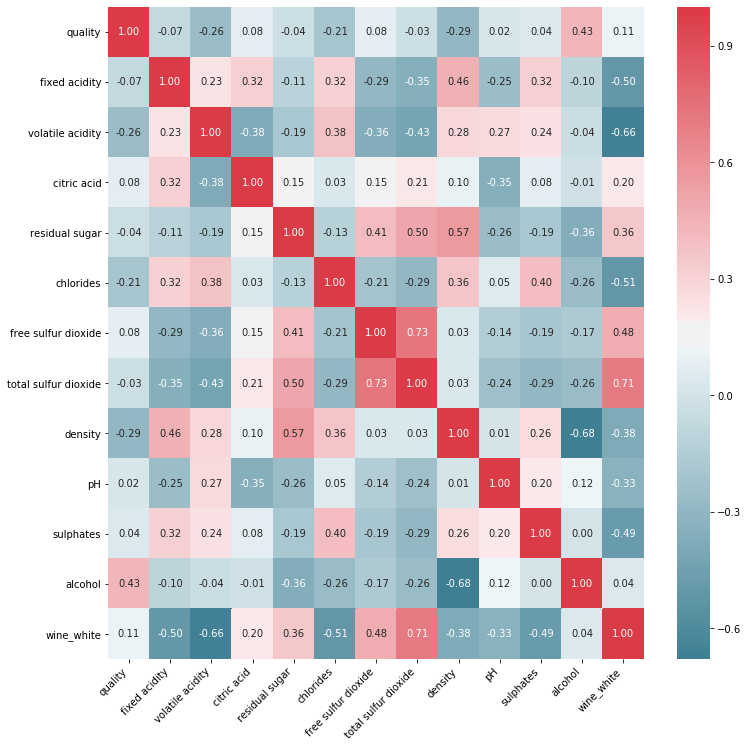

In [11]:
colum_names = [ 'quality','fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
               'free sulfur dioxide', 'total sulfur dioxide','density', 'pH', 'sulphates', 'alcohol','wine_white']
# Correlation matrix
correlations = df_train.corr()
# Plot figsize
fig, ax = plt.subplots(figsize=(12, 12))
'''
With color map is easier to see if the correlation is strong or not, positive or negative.
'''
# Generate Color Map
colormap = sns.diverging_palette(220, 10, as_cmap=True)
# Generate Heat Map, allow annotations and place floats in map
sns.heatmap(correlations, cmap=colormap, annot=True, fmt=".2f")
ax.set_xticklabels(
    colum_names,
    rotation=45,
    horizontalalignment='right'
);
ax.set_yticklabels(colum_names);
plt.show()

**The correlation of *total sulfur dioxide* with *free sulfur dioxide* and *wine white* (wine) is high ( 0.73 and 0.71 respectively). Moreover there is negative strong corralation between *alcohol* and *density* , *volatile acidity* and type of wine (*wine_white*).**

**To be sure that the type of wine (red/white) does not affect the quality of the wine we check the mean of the quality for each type.**

In [12]:
'''
To check the mean of the quality for the two types of wine, red/white, we use the wine_train (the origin data).
'''
# check if the mean in differnet kind of wine is different
df_white = wine_train.loc[wine_train["wine"] == "white"]
df_red = wine_train.loc[wine_train["wine"] == "red"]
print("white mean = ",df_white["quality"].mean())
print("red mean =",df_red["quality"].mean())

white mean =  5.850488021295475
red mean = 5.620643431635389


**The mean of the quality in the two types of wine is almost the same, so we can say that the type of wine alone does not affect importantly quality of the wine.**

**It is very important to see if there are differences between the four categories and some features.**

**We are going to check the four categories and the features which have the strongest correlation: *alcohol*, *chlorides*,*volatile_acidity*, and *density*.**

**One easy way to see if there are differences is to make some boxplots**

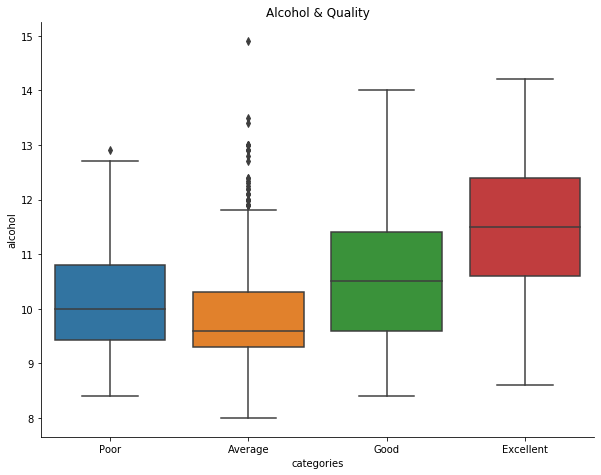

In [11]:
'''
Alcohol & Quality
'''
sns.catplot(x='quality_cat', y='alcohol', 
            data=df_final,
            kind='box',order=["Poor","Average","Good","Excellent"] ,height=6.5, aspect=1.3)
plt.xlabel('categories');
plt.title('Alcohol & Quality');

**The mean of the alcohol in the quality category "Excellent", is higher than the others and the lowest is the mean of alcohol for the quality category "Average", which has the lowest variance too.**

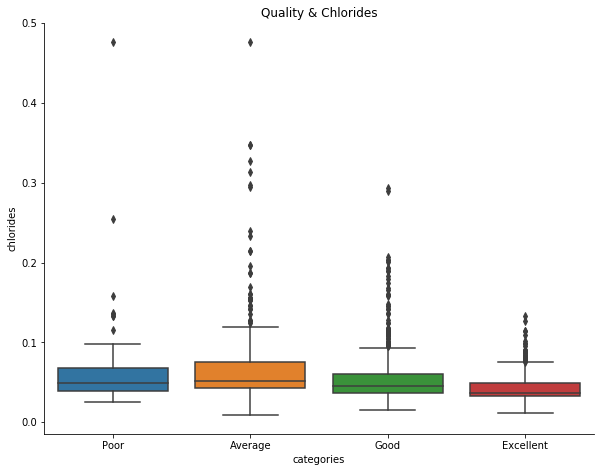

In [35]:
'''
Chlorides & Quality
'''
sns.catplot(x='quality_cat', y='chlorides', 
            data=df_final,
            kind='box',order=["Poor","Average","Good","Excellent"] ,height=6.5, aspect=1.3)
plt.xlabel('categories');
plt.title('Quality & Chlorides');

**The mean of chlorides is almost the same for all quality categories.**

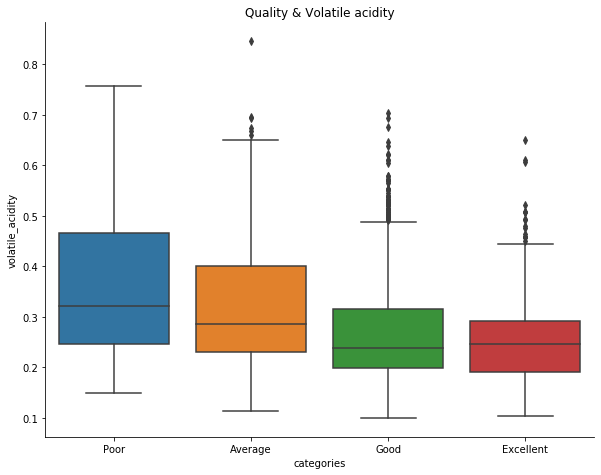

In [36]:
'''
Chlorides & Quality
'''
sns.catplot(x='quality_cat', y='volatile_acidity', 
            data=df_final,
            kind='box',order=["Poor","Average","Good","Excellent"] ,height=6.5, aspect=1.3)
plt.xlabel('categories');
plt.title('Quality & Volatile acidity');


**The quality category "Poor" has the highest mean of volatile acidity, however has and the hiest variance. The quality category "Good" has the lowest mean.**

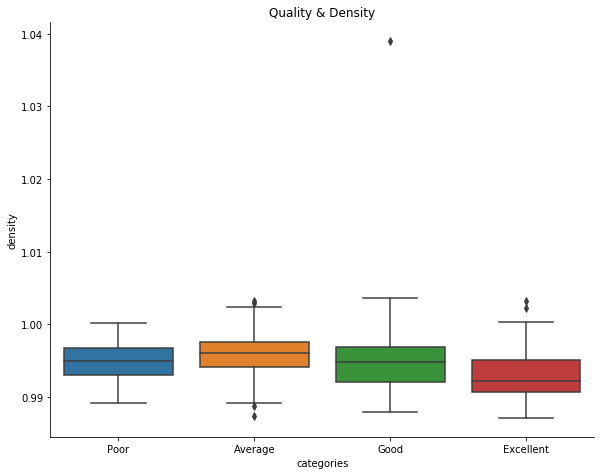

In [37]:
'''
Density & Quality
'''
sns.catplot(x='quality_cat', y='density', 
            data=df_final,
            kind='box',order=["Poor","Average","Good","Excellent"] ,height=6.5, aspect=1.3)
plt.xlabel('categories');
plt.title('Quality & Density');

**The quality category "Average" has the highest mean of density and all the categories have small variance.**

**Another thing that is may useful is to observe the histograms of some features for the four quality categories.**

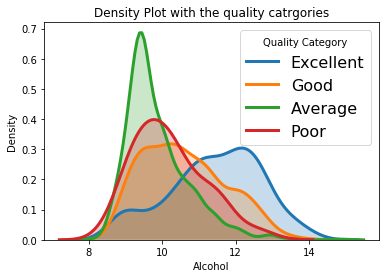

In [64]:
# List of four quality categories to plot
categories = ['Excellent', 'Good', 'Average','Poor']

'''
Alcohol & Quality
'''

# Iterate through the four quality categories
for k in categories:
    subset = df_final[df_final['quality_cat'] == k]
    
    # Draw the density plot
    sns.distplot(subset['alcohol'], hist = False, kde = True,
                 kde_kws = {'shade': True,'linewidth': 3},
                 label = k)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Quality Category')
plt.title('Density Plot with the quality catrgories')
plt.xlabel('Alcohol')
plt.ylabel('Density');

**As we can see the density of alcohol for each quality category is different. For example for "Average", the density is positive skewed but for the others categories seems to follow normal distribution.**

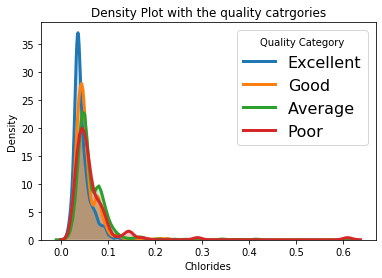

In [66]:
'''
Chlorides & Quality
'''
# Iterate through the four quality categories
for k in categories:
    subset = df_final[df_final['quality_cat'] == k]
    
    # Draw the density plot
    sns.distplot(subset['chlorides'], hist = False, kde = True,
                 kde_kws = {'shade': True,'linewidth': 3},
                 label = k)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Quality Category')
plt.title('Density Plot with the quality catrgories')
plt.xlabel('Chlorides')
plt.ylabel('Density');

**The densities for the four categories seems to hav esimilar shape, however they have difference mode with the mode of "Excellent" to be the highest and the mode of "Poor" to be the lowest.**

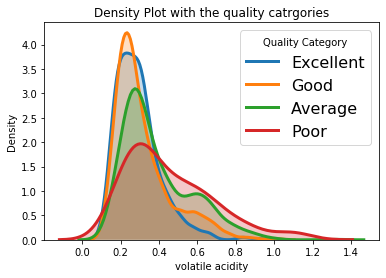

In [65]:
'''
Volatile acidity & Quality
'''
# Iterate through the four quality categories
for k in categories:
    subset = df_final[df_final['quality_cat'] == k]
    
    # Draw the density plot
    sns.distplot(subset['volatile_acidity'], hist = False, kde = True,
                 kde_kws = {'shade': True,'linewidth': 3},
                 label = k)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Quality Category')
plt.title('Density Plot with the quality catrgories')
plt.xlabel('volatile acidity')
plt.ylabel('Density');

**There are differences between the densities of the four categories. The mode of "Poor" category is the lowest and is almost the half of the mode of "Good" which is the highest.**

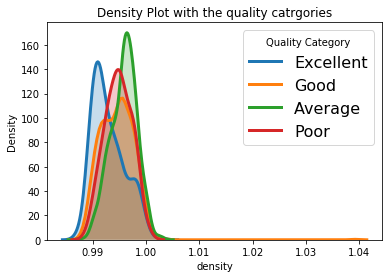

In [67]:
'''
Density & Quality
'''
# Iterate through the four quality categories
for k in categories:
    subset = df_final[df_final['quality_cat'] == k]
    
    # Draw the density plot
    sns.distplot(subset['density'], hist = False, kde = True,
                 kde_kws = {'shade': True,'linewidth': 3},
                 label = k)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Quality Category')
plt.title('Density Plot with the quality catrgories')
plt.xlabel('density')
plt.ylabel('Density');

**The densities of the four categories seems to have zero skew so we can suppose that the skew of the *density* is zero.**

**Finally we check the histograms and densities of the orgin data to check the skew of all the features.**

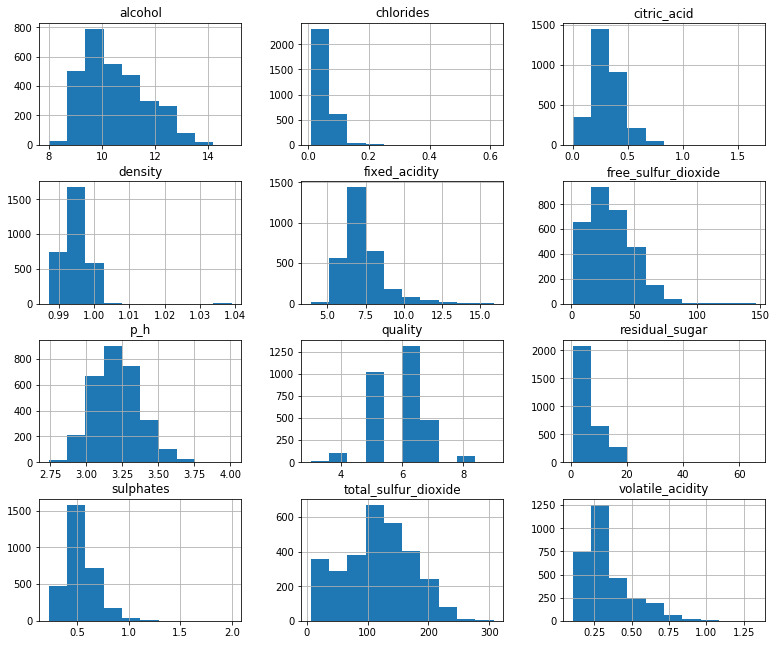

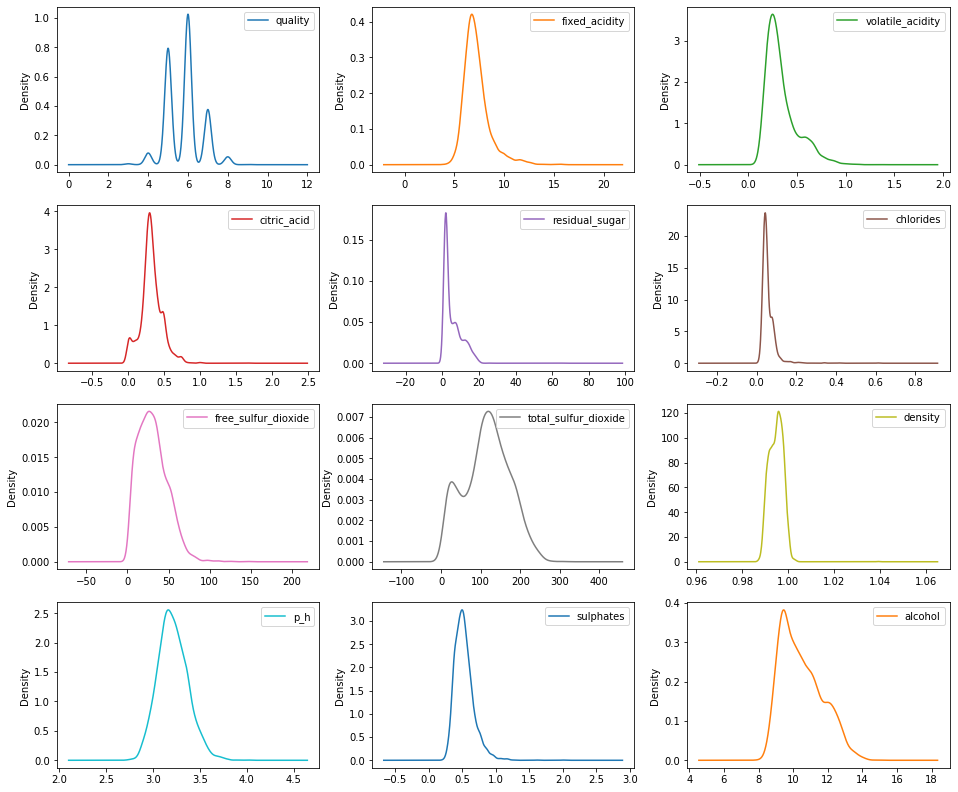

In [58]:
# Histograms
wine_train.hist(bins=10,figsize=(13, 11))
plt.show()
# Density
wine_train.plot(kind='density', subplots=True, layout=(4,3), sharex=False,figsize=(16, 14))
plt.show()

**Data distribution for attribute  "chlorides" is positively skewed, for attribute “p_h” ,"citric_acid" data quite normally distributed. Moreover we can see there are more entries for the catogories "Poor"and "Excellent".**

**We can find exactly the skew of each feature.**

In [12]:
# Check the skew of all numerical features
numeric_feats = wine_train.dtypes[wine_train.dtypes != "object"].index
skewed_feats = wine_train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness

,Skewed Features
chlorides,5.804736
fixed_acidity,1.678983
residual_sugar,1.637279
sulphates,1.490431
volatile_acidity,1.394833
density,0.930527
free_sulfur_dioxide,0.806579
alcohol,0.593671
citric_acid,0.562053
p_h,0.397724


**Chlorides, fixed_acidity, residual_sugar, sulphates and volatile_acidity are positive skewd so we have to transform them for some models that we are going to use.**

In [13]:
# We use log to decrease the skew
df_skew = df_final
df_skew['chlorides'] = np.log(df_skew['chlorides']+1)
df_skew['fixed_acidity'] = np.log(df_skew['fixed_acidity']+1)
df_skew['residual_sugar'] = np.log(df_skew['residual_sugar']+1)
df_skew['sulphates'] = np.log(df_skew['sulphates']+1)
df_skew['volatile_acidity'] = np.log(df_skew['volatile_acidity']+1)
skewed_feats = df_skew[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness

,Skewed Features
chlorides,4.666494
volatile_acidity,1.084124
fixed_acidity,0.944147
density,0.930527
sulphates,0.926615
free_sulfur_dioxide,0.806579
alcohol,0.593671
citric_acid,0.562053
p_h,0.397724
residual_sugar,0.390309


**We check the different models with and without the transformation (reduction of the skew) and found that there is no difference in our results, so we chose to work with the original data.**

### Oversampling

**The difference in the number of entries on the quality categories "Poor" and "Excellent" is sizeable.**

**So we have to preprocess the imbalanced data before we feed them into a classifier because if not the classifiers usually are more sensitive to detecting the majority classes and less sensitive to the minority classes. Thus, if we do not take care of the issue, the classification output will be biased, in many cases resulting in always predicting the majority classes.**

**In order to balance the classes, under-sampling or oversampling techniques can be implemented. One method that we used is SMOTE (Synthetic Minority Over-sampling Technique) in order to balance the classes in the dataset and predict the wine quality. 
SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.
Specifically, a random example from the minority class is first chosen. Then 5 of the nearest neighbors for that example are found. A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space. Five nearest neighbors are used to create the artificial samples, thus ensuring that the artificial samples are representative and realistic for this dataset.**

**Another method that we used is ADASYN, which builds on the methodology of SMOTE, by shifting the importance of the classification boundary to those minority classes which are difficult. ADASYN uses a weighted distribution for different minority class examples according to their level of difficulty in learning, where more synthetic data is generated for minority class examples that are harder to learn.**

**We applied both methods and we observed that ADASYN had better results, so we kept onyl ADASYN method.**

In [14]:
! pip install imblearn

In [15]:
wine_train = wine_train.drop(['quality'], axis=1)
wine_train.wine = pd.get_dummies(wine_train.wine, drop_first=True)
wine_test = wine_test.drop(['quality'], axis=1)
wine_test.wine = pd.get_dummies(wine_test.wine, drop_first=True)

y_train = wine_train.quality_cat
x_train = wine_train.drop(['quality_cat'], axis=1)

y_test = wine_test.quality_cat
x_test = wine_test.drop(['quality_cat'], axis=1)

In [16]:
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_train = ADASYN().fit_sample(x_train, y_train)
x_train = pd.DataFrame(X_resampled, columns=x_train.columns.values)

## 3. Model Fitting and Tuning

**We applied 8 classifiers : Logistic Regression, Lasso, ElasticNet, Ridge, Naive Bayes, SVM, Gradient Boost and Random Forest. The classifiers were run on their natural form, One vs. One, One vs. All and Output code multi-class strategy.
Comparing the precision, recall, f1-score,accuracy and unweighted (macro) and weighted averages of all three metrics as evaluation metrices of these models we came up with the choice of the Random Forest model which had the highest F1 score.
Although Random forest and the decision tree models are the most prone to overfitting and are sensitive to the choice of tuning parameters in our case seems to be the best model as the F1 score( and the others metrices are the highest). Additionally, we employed grid search in order to find the optimal parameters for the best model.**


**We are consider precision, recall, f1-score,accuracy, macro avg, weighted avg as evaluation metrices for the models, but for our final model selection we use F1 score.
F1 score  is a function of Precision and Recall. F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall and there is an uneven class distribution, like in our case.**

**F1 Score = 2*(Recall * Precision) / (Recall + Precision)**


**Thinking that except of a high value of F1 score and the performance of a model, it is important to have a simple model with the most important features.
To achieve that we can use recursive feature elimination (RFE) to select features, in the Random Forest model.**

**Recursive feature elimination (RFE) selects features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached. We check for the highest score for all the models tha include from 1 to 12 explanatory variables.**


In [17]:


clf = RandomForestClassifier(n_estimators=150, max_depth=30, min_samples_split = 2, max_features='sqrt')

print(run_model(clf, x_train, y_train, x_test, y_test, multi='none'))

C:\Users\Andreas\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Train score:  1.0
Test score:  0.6008772389168717


C:\Users\Andreas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Andreas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross validation score:  0.570697837055616
           Poor  Average  Good  Excellent
Poor         11       19    25          8
Average      19      220    71          7
Good         13       70   262         75
Excellent     1       16    71        112
             precision    recall  f1-score   support

    Average       0.68      0.69      0.69       317
  Excellent       0.55      0.56      0.56       200
       Good       0.61      0.62      0.62       420
       Poor       0.25      0.17      0.21        63

avg / total       0.60      0.60      0.60      1000



C:\Users\Andreas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
n_estimators = [50,100,150,200]
max_features = ['auto', 'sqrt']
max_depth = [10, 20, 30, 40, 50]
min_samples_split = [2, 5, 10]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}
print(random_grid)

{'n_estimators': [50, 100, 150, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50], 'min_samples_split': [2, 5, 10]}


In [19]:
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter=100, verbose=2, random_state=42, n_jobs = 4)
# Fit the random search model
rf_random.fit(x_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   17.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  2.4min finished


{'n_estimators': 200,
 'min_samples_split': 2,
 'max_features': 'sqrt',
 'max_depth': 20}

In [21]:
# apply recursive feature elimination (RFE) to select features
for i in range(1,len(x_train.columns)):
    print(run_rfe_and_score_best_feature(rf_random.best_estimator_, x_train, y_train, x_test, y_test,i))

--------------------------------------------------------------
Running  RandomForestClassifier
Train score:  0.7692632956415371
Test score:  0.4290202192123928
Cross validation score:  0.3931546027778357
['density']
--------------------------------------------------------------
Running  RandomForestClassifier
Train score:  0.9549214092037922
Test score:  0.5178070847666866
Cross validation score:  0.4730203513037067
['density', 'alcohol']
--------------------------------------------------------------
Running  RandomForestClassifier
Train score:  0.9996075350078384
Test score:  0.49804268747102304
Cross validation score:  0.48272423025015054
['total_sulfur_dioxide', 'density', 'alcohol']
--------------------------------------------------------------
Running  RandomForestClassifier
Train score:  0.9998037673469278
Test score:  0.5475708986298683
Cross validation score:  0.5260880237797989
['volatile_acidity', 'total_sulfur_dioxide', 'density', 'alcohol']
---------------------------------

RandomForestClassifier :

Train score:  1.0
Test score:  0.5993066881083411


C:\Users\Andreas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Andreas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Andreas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross validation score:  0.5740775061414173
           Poor  Average  Good  Excellent
Poor         11       18    27          8
Average      19      218    71          6
Good         13       71   254         67
Excellent     1       18    77        121
             precision    recall  f1-score   support

    Average       0.67      0.69      0.68       314
  Excellent       0.60      0.56      0.58       217
       Good       0.59      0.63      0.61       405
       Poor       0.25      0.17      0.20        64

avg / total       0.60      0.60      0.60      1000

-----------------------------
One vs. One: 

Train score:  1.0
Test score:  0.6031721198808702


C:\Users\Andreas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Andreas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross validation score:  0.5622293404482221
           Poor  Average  Good  Excellent
Poor          9       23    24          6
Average      23      220    76          7
Good         12       72   263         74
Excellent     0       10    66        115
             precision    recall  f1-score   support

    Average       0.68      0.67      0.68       326
  Excellent       0.57      0.60      0.59       191
       Good       0.61      0.62      0.62       421
       Poor       0.20      0.15      0.17        62

avg / total       0.60      0.61      0.60      1000

-----------------------------
One vs. Rest: 

Train score:  1.0
Test score:  0.6055896224194


C:\Users\Andreas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Andreas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross validation score:  0.5737436396437996
           Poor  Average  Good  Excellent
Poor         10       20    29          5
Average      21      223    73          6
Good         11       67   259         73
Excellent     2       15    68        118


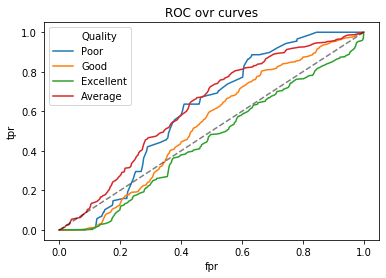

             precision    recall  f1-score   support

    Average       0.69      0.69      0.69       323
  Excellent       0.58      0.58      0.58       203
       Good       0.60      0.63      0.62       410
       Poor       0.23      0.16      0.19        64

avg / total       0.60      0.61      0.61      1000

-----------------------------
Output correction: 

Train score:  0.9994113006706916
Test score:  0.38295417000546833


C:\Users\Andreas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Andreas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Andreas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross validation score:  0.49839837619569527
           Poor  Average  Good  Excellent
Poor         26      115   189         67
Average      14      177    43          4
Good          4       29   149         29
Excellent     0        4    48        102
             precision    recall  f1-score   support

    Average       0.54      0.74      0.63       238
  Excellent       0.50      0.66      0.57       154
       Good       0.35      0.71      0.47       211
       Poor       0.59      0.07      0.12       397

avg / total       0.52      0.45      0.38      1000

None


In [26]:
print(run_all(rf_random.best_estimator_, x_train, y_train, x_test, y_test))

**After running RFE, we found that the model produces the best results if all the features are used. This might be explained by the fact that the features were not highly correlated.**

**Furthermore, using the 4 multi-class methods on the Random Forest algorithm we found that the best results are given from the natural format of the algorithm.**

In [38]:
best = rf_random.best_estimator_

## 4. Discussion


*In this section you should provide a general overview of your final model and its performance. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant. The target audience for this should be someone who is familiar with the basics of mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. Your goal should be to convince this audience that your model is both accurate and useful. Your discussion should also include some discussion of differences in potential losses incurred by misclassification - i.e. classifying a "poor" wine as "excellent" is likely not the same as misclassifying an "excellent" wine as "good".*

**The basic idea of trees is to segment the feature space into a number of smaller, simpler, non-overlapping regions
(R1, R2, . . . , RN ). Each region is then assigned to a single class.
Decision trees as they are the building blocks of the random forest model.**

**Random forest, like its name implies, consists of a large number of individual decision trees that operate as an ensemble. 
Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction.
General, the reason that the random forest model works so well is that a large number of relatively uncorrelated models (trees) operating as a committee will outperform any of the individual constituent models.**

**A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.** 

**There are a number of advantages of trees compared to alternative methods. Trees are very simple to illustrate and explain to non-specialist. They mirror closely human decision-making.**

**Our final model contains all of the features and with this model we can acurate predict the quality category of a wine.**

In [28]:
print(run_model(best, x_train, y_train, x_test, y_test))

Train score:  1.0
Test score:  0.5958388069282967


C:\Users\Andreas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Andreas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross validation score:  0.5762222961519073
           Poor  Average  Good  Excellent
Poor         11       20    26          7
Average      19      214    82          6
Good         13       74   255         69
Excellent     1       17    66        120
             precision    recall  f1-score   support

    Average       0.66      0.67      0.66       321
  Excellent       0.59      0.59      0.59       204
       Good       0.59      0.62      0.61       411
       Poor       0.25      0.17      0.20        64

avg / total       0.59      0.60      0.60      1000



C:\Users\Andreas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**We observe that the cross validation score is 0.576. The f1 score for the four quality categories are : Excellent - 0.59, Good - 0.61, Average - 0.66 and Poor - 0.20. The f1-score of "Poor", as with precision and recall, is the lowest with big difference from the others.**

**Furthermore, we can see that in potential losses incurred by misclassification, we have high accuracy as misclassifying one category with the next/previous category. The only category that we do not have high accuracy by misclassification is the "Poor", and this is one implication of our model. One possible reason for that, is that as we observed in exploratory analysis, the density of the "Poor "category of some features (eg. alcohol) gets the same values as the density of the other categories - the density of category "Poor" is under the densities of the other categories, and there is no clear separation of the values of the characteristics for category "Poor"and the other three categories.**

In [34]:
pd.DataFrame(best.feature_importances_, x_train.columns).sort_values(0, ascending =False)

,0
alcohol,0.116724
volatile_acidity,0.095791
total_sulfur_dioxide,0.088737
density,0.086702
free_sulfur_dioxide,0.085365
residual_sugar,0.083297
chlorides,0.083009
sulphates,0.079512
fixed_acidity,0.079293
p_h,0.077213


**From the features importance matrix we notice that the feature with the highest contribution to the prediction of the quality is the alcohol. This is something that we expected as the correlation between quality and alcohol is the highest (we see it in the part of exploratory analysis). Moreover the volatile_acidity is important for the prediction of the quality which is something that we expected also.**

## 5. Model Validation

*We have provided a third csv file called `wine_qual_holdout.csv` which we will be using for assessing the predictive performance of your model. The file provided with the assignment contains **identical** data to `wine_qual_test.csv`, however after you turn in your notebook we will be replacing this file with the true holdout data (1000 additional wines not included in the train or test set) and rerunning your notebook.*

*The objective of this is two-fold, the first is to ensure that your modeling code is reproducible and everything can be rerun and "identical" results can be obtained. And second, to obtain a reliable estimate of your final model's predictive performance, which will be compared across all of the projects in the course.*

*You should include a brief write up in the section detailing the performance of your model, in particular you should discuss the implications of this modeling uncertainty in the context of classifying wine quality.*

**We use the csv file called wine_qual_holdout.csv for assessing the predictive performance of our model.**

In [39]:
wine_holdout = pd.read_csv("wine_qual_holdout.csv")

wine_holdout["quality_cat"] = ""
for i, row in wine_holdout.iterrows():
    if (wine_holdout.loc[i,'quality'] >=0) & (wine_holdout.loc[i,'quality'] <5):
        wine_holdout.loc[i,"quality_cat"] = "Poor"
    elif wine_holdout.loc[i,'quality'] ==5:
        wine_holdout.loc[i,"quality_cat"] = "Average"
    elif wine_holdout.loc[i,'quality'] ==6:
        wine_holdout.loc[i,"quality_cat"] = "Good"
    else:
        wine_holdout.loc[i,"quality_cat"] = "Excellent"

wine_holdout.wine = pd.get_dummies(wine_holdout.wine, drop_first=True)

# Adjust this code as necessary to preprocess the holdout data
X_holdout = wine_holdout.drop(['quality','quality_cat'], axis=1)
y_holdout = wine_holdout.quality_cat

In [42]:
final_model = best

In [43]:
# Calculate the confusion matrix for our model
sklearn.metrics.confusion_matrix(y_holdout, final_model.predict(X_holdout))

array([[214,  17,  74,  20],
       [  6, 120,  69,   7],
       [ 82,  66, 255,  26],
       [ 19,   1,  13,  11]], dtype=int64)

In [44]:
# Calculate the classification report for our model
print(sklearn.metrics.classification_report(y_holdout, final_model.predict(X_holdout)))

             precision    recall  f1-score   support

    Average       0.67      0.66      0.66       325
  Excellent       0.59      0.59      0.59       202
       Good       0.62      0.59      0.61       429
       Poor       0.17      0.25      0.20        44

avg / total       0.61      0.60      0.60      1000



**The f1 score for the four quality categories are : Excellent - 0.59, Good - 0.61, Average - 0.66 and Poor - 0.20. The scores are close to the scores that we had by using the train and test data, even if our data is unseen. As a result of that we can say that our model is not uncertain because of its performance.**